**NOME:** Eduardo Fontes Baltazar da Silveira

# 🙈 Escondendo os detalhes

Aqui estão os códigos detalhados que foram utilizados para gerar as visualizações do notebook. Não é necessário entender esse código, pois o curso não é voltado para o desenvolvimento de modelos de linguagem e sim a utilização prática de modelos prontos. Basta executar as células escondidas e seguir em frente.



```
🤓 Aqueles que tiverem interesse podem se aventurar analisando o código e tirar dúvidas nas monitorias ou pelo classroom
```

## Dependências

In [87]:
!pip install transformers[sentencepiece]

In [88]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM

from tabulate import tabulate
from google.colab import widgets as cwidgets

import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets, interactive_output

## Definições das Funções

In [89]:
COLORS = [5,9,34,62,93,208]

# Formata a sting para ter uma cor de fundo
def colored(txt: str, idx: int):
    color = COLORS[idx%len(COLORS)]
    return f"\x1B[1m\x1B[48;5;{color}m{txt}\x1B[0m"

In [90]:
#MODEL_NAME = 'unicamp-dl/translation-en-pt-t5'
MODEL_NAME = 'Helsinki-NLP/opus-mt-tc-big-en-pt'
# Inicializando o tokenizador e modelo a serem usados
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, output_attentions=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [91]:
# Separa uma string em tokens e imprime cada token com uma cor de fundo
def print_colored_tokens(text: str):
    # Realiza a tokenização
    tokens = tokenizer.tokenize(text)

    # Imprime os tokens com diferentes cores
    print('\x1B[1mDivisão do Texto\x1B[0m:\t', end='')
    for idx, token in enumerate(tokens):
        print(colored(token.replace("▁", " "), idx), end='')

    print('\n\x1B[1mTokens Ids\x1B[0m:\t\t' + str(tokenizer(text)['input_ids'][:-1]))

In [92]:
k=6

def print_embeddings(text, hidden_states):
    #Tokeniza o texto
    tokens = tokenizer.tokenize(text)

    # Número de camadas de atenção do modelo
    n_layers = len(hidden_states)

    # Cria uma visualização em abas para cada layer do modelo
    tb = cwidgets.TabBar(['inputs'] + ['layer ' + str(i+1) for i in range(n_layers - 1)])
    for layer in range(n_layers):
        with tb.output_to(layer, select=(layer==0)):

            # Inicializa a lista de dados para a tabela de embeddings
            # Adiciona os tokens como headers e prepara lista vazias para
            # receberem os embeddings
            data = []
            data.append([colored(token.replace("▁",""), idx) for idx, token in enumerate(tokens)])
            [data.append([]) for _ in range(k+1)]

            # Itera sobre os tokens e embeddings para preencher a tabela
            for i, _ in enumerate(tokens):
                # Concatena os primeiros e últimos k//2 valores do embedding
                token_embedding = hidden_states[layer][0][i][:k//2].tolist() + hidden_states[layer][0][i][-k//2:].tolist()
                for j, val in enumerate(token_embedding):
                    data[j+1].append(f"{val:.3f}")

            # Insere '...' no meio dos valores
            data.insert(k//2+1, ["..."]*len(tokens))

            print(tabulate(data, headers="firstrow", tablefmt="plain"))

In [93]:
import matplotlib.pyplot as plt
def print_input_embeddings(text, hidden_states):
    #Tokeniza o texto
    tokens = tokenizer.tokenize(text)

    # Inicializa a lista de dados para a tabela de embeddings
    # Adiciona os tokens como headers e prepara lista vazias para
    # receberem os embeddings

    embed_size = 150

    fig, axs = plt.subplots(len(tokens), 1, figsize=(15,len(tokens)//1.2))
    fig.patch.set_visible(False)
    # Itera sobre os tokens e embeddings para preencher a tabela
    for i, token in enumerate(tokens):
        token_embedding = hidden_states[0][0][i+1, :embed_size].unsqueeze(0).tolist()
        img = axs[i].imshow(token_embedding, cmap='Spectral', extent=[0,embed_size,0,embed_size//20])
        axs[i].set_frame_on(False)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(token, rotation=0, verticalalignment='center', horizontalalignment='right')


    plt.colorbar(img, ax=axs)
    plt.show()

In [94]:
def plot_encoder_attentions_maps(Input, attentions):
    tokens = tokenizer.tokenize(Input)

    n_heads = 4

    attention = attentions[0][0]
    fig, axs = plt.subplots(1, n_heads, figsize=(len(tokens)*2,len(tokens)//1.7), sharey=True)

    for head in range(n_heads):
        att_matrix = attention[head+4,1:-1,1:-1].detach().numpy()
        img = axs[head].imshow(att_matrix, cmap='Blues')

        # Set ticks and labels
        axs[head].set_xticks(range(len(tokens)))
        axs[head].set_yticks(range(len(tokens)))
        axs[head].set_xticklabels(tokens, rotation=90, ha='right')
        axs[head].set_yticklabels(tokens)
        axs[head].set_title(f'Head {head+1}')

    plt.colorbar(img, ax=axs)
    plt.show()

In [95]:
def plot_encoder_decoder_attentions_maps(input, output_seq, attentions):
    in_tokens = tokenizer.tokenize(input)
    #out_tokens = tokenizer.tokenize(output)
    out_tokens = [tokenizer.decode(id) for id in output_seq[0][1:-1]]

    n_heads = 5

    attention = attentions[4][0]
    fig, axs = plt.subplots(1, n_heads, figsize=(len(in_tokens)*2,len(out_tokens)//1.7), sharey=True)

    for head in range(n_heads):
        att_matrix = attention[head,2:-1,1:-1].detach().numpy()
        img = axs[head].imshow(att_matrix, cmap='Blues')

        # Set ticks and labels
        axs[head].set_xticks(range(len(in_tokens)))
        axs[head].set_yticks(range(len(out_tokens)))
        axs[head].set_xticklabels(in_tokens, rotation=90, ha='right')
        axs[head].set_yticklabels(out_tokens)
        axs[head].set_title(f'Head {head+1}')

    plt.colorbar(img, ax=axs)
    plt.show()

In [96]:
def plot_softmax(logits, temperature: float = 1):
    scores = logits[0,0,:].clone().detach()
    if (temperature > 0):
        scores /= temperature
        softmax = torch.nn.functional.softmax(scores, dim=-1,)
        top_probs, top_indices = torch.topk(softmax, k=10)
    else:
        softmax = torch.nn.functional.softmax(scores, dim=-1,)
        top_probs, top_indices = torch.topk(softmax, k=10)
        top_probs[0] = 1.0
        top_probs[1:] = 0


    print()
    plt.figure(figsize=(10, 4))
    plt.bar([tokenizer.decode(int(ind)) for ind in top_indices], top_probs, color='skyblue')
    plt.xlabel('Probability')
    plt.ylabel('Token')
    plt.title('Top 10 Softmax Scores for Output Tokens')
    plt.tight_layout()
    plt.show()

def sample_outputs(temperature: float = 1, n_samples: int = 5):
    print(f'\n Exemplos de frases amostradas com temperatura {temperature}\n')
    for i in range(n_samples):
        output_seq = run_model(Input, temperature=temperature, output_hidden_states=False)
        print(f'{i+1}) ' + tokenizer.decode(output_seq[0], skip_special_tokens=True))

In [97]:
def run_model(text: str, temperature: float = 0.0, output_hidden_states: bool = True):
    #Tokeniza o texto
    tokens = tokenizer.tokenize(text)

    # Computa os ids dos tokens
    inputs = tokenizer(text, return_tensors='pt')

    with torch.no_grad():
    #Realiza a inferência do modelo e recupera os estados internos do modelo
        if temperature > 0:
            output_seq = model.generate(**inputs, do_sample=True, temperature=temperature, max_length=50)#, forced_bos_token_id=tokenizer.lang_code_to_id['pt_XX'])
            if output_hidden_states:
                outputs = model(**inputs, decoder_input_ids=output_seq, output_hidden_states=True, output_attentions=True)
        else:
            output_seq = model.generate(**inputs, max_length=50)#, forced_bos_token_id=tokenizer.lang_code_to_id['pt_XX'])
            if output_hidden_states:
                outputs = model(**inputs, decoder_input_ids=output_seq, output_hidden_states=True, output_attentions=True)

    # Retorna o resultado da camada linear de saída e os estados internos
    if output_hidden_states:
        return output_seq, outputs.logits, outputs.encoder_hidden_states, outputs.decoder_hidden_states, outputs.encoder_attentions, outputs.cross_attentions
    else:
        return output_seq

# 🧐 Entendendo o Transformer

A arquitetura [original do transformer](https://arxiv.org/abs/1706.03762) é um modelo auto-encoder seq2seq baseado inteiramente em self-attention. De forma mais detalhada, o transformer é um modelo que:
- 1. Converte uma entrada para uma representação vetorial comprimida e então gera uma saída, do mesmo tipo da entrada, a partir da representação (auto-encoder);
- 2. Aceita como entrada uma sequência de dados e produz como saída uma sequência de dados, onde a ordem dos itens na sequência é importante, como em textos e séries temporais (seq2seq);
- 3. Utiliza somente o mecanismo de atenção (particularmente o self-attention) para tratar a relação temporal entre os itens das sequências de entrada e saída.

## 🛠 Processamento passo-a-passo

Vamos analisar o passo-a-passo do funcionamento de um transformer. O modelo estudado será o [OPUS-mt English to Portuguese](https://huggingface.co/Helsinki-NLP/opus-mt-tc-big-en-pt), o qual é um transformer encoder-decoder (com alguns truques extras 😉) treinado para realizar a tradução de textos do inglês para o português.

A arquitetura do transformer possui dois componentes principais: o encoder e o decoder. Ambos são formados por blocos de processamento empilhados, os quais realizam as mesmas operações, mas mantém um conjunto de parâmetros próprio.

O encoder gera uma representação vetorial da sentença de entrada. Ele é composto por uma camada de self-attention, o qual permite a modificação do embedding de cada token com base nos embeddings dos demais tokens, e uma camada linear, que modifica cada token independentemente.

O decoder gera a sentença de saída 'palavra por palavra' utilizando a representação criada pelo encoder. Ele possui as mesmas duas camadas que o encoder e uma camada extra entre elas que realiza a atenção entre os tokens do decoder com os tokens do último bloco do encoder, permitindo que a saída agregue informações da entrada.

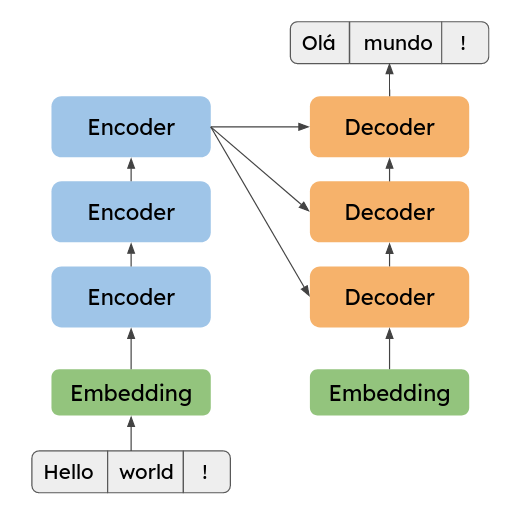

# <img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figura 1: Aplicando o transformer para tradução de máquina. Fonte: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

In [98]:
# @title Primeiramente vamos selecionar um texto para tradução, o qual será a entrada do modelo.
Input = "Welcome to the course! Let's have fun!" # @param @type {type: "string"}

### Tokens

Para que o transformer possa processar dados textuais, os mesmos devem ser transformados em vetores numéricos. Para isso, a entrada é dividida em **tokens** com base em um dicionário previamente definido.

Os dicionários costumam ser únicos para cada modelo e as palavras ou sub-palavras presentes neles são escolhidas pela taxa de ocorrência das mesmas nos dados de treinamento. Os dicionários mapeiam cada token (palavra ou sub-palavra) para um índice (token id).


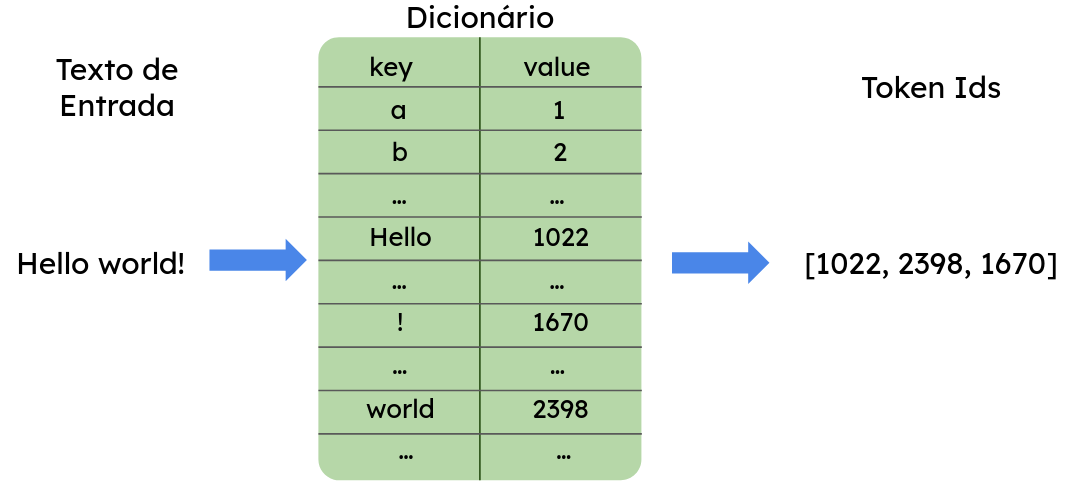

In [99]:
print_colored_tokens(Input)

Divisão do Texto:	 Welcome to the course! Let's have fun!
Tokens Ids:		[53949, 50317, 49848, 13474, 15, 30153, 43, 44669, 24845, 22966, 15]


### Embeddings

Para permitir que os transformers representem melhor a informação simbólica que cada token id representa são utilizados embeddings. Embeddings são vetores de alta dimensão que representam uma informação simbólica de forma distribuída. Ao operarem sobre embeddings ao invés de token ids, os modelos possuem mais liberdade para focar e/ou alterar partes específicas da informação de um token.

A camada de embedding inicial de um transformer consiste um uma tabela simples, onde cada linha é um vetor de embedding. Dessa forma, o modelo simplesmente seleciona as linhas correspondentes aos token ids de entrada e forma uma sequência de embeddings para entrada do encoder ou decoder.

[//]: # (Após isso, cada camada do transformer irá modificar um pouco esses embeddings gerando uma representação final para cada token. No caso do encoder, essa representação é utilizada pelo decoder como 'guia' para geração do texto de saída. Já no decoder, a representação final dos embeddings é utilizada para gerar a probabilidade de cada token de ser o próximo item na sequência de saída.)

Vamos visualizar abaixo uma parte dos embeddings de entrada do encoder. O valor de cada índice do vetor de embedding será representado por um retângulo com cor proporcional a seu valor. Pode-se reparar como a informação que um token carrega é distribuída pelo vetor, tendo valores positivos e negativos em cada posição, indicando a importância da dimensão para a interpretação do token.

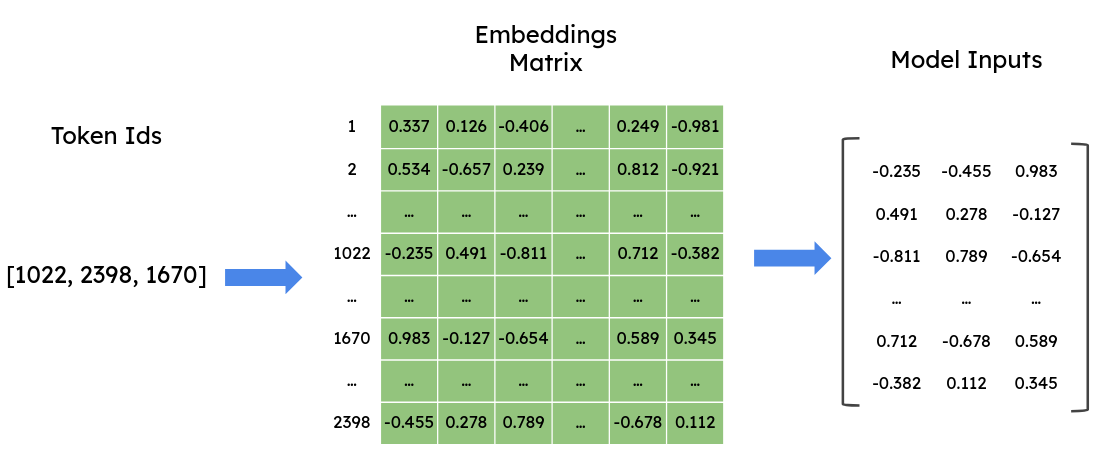

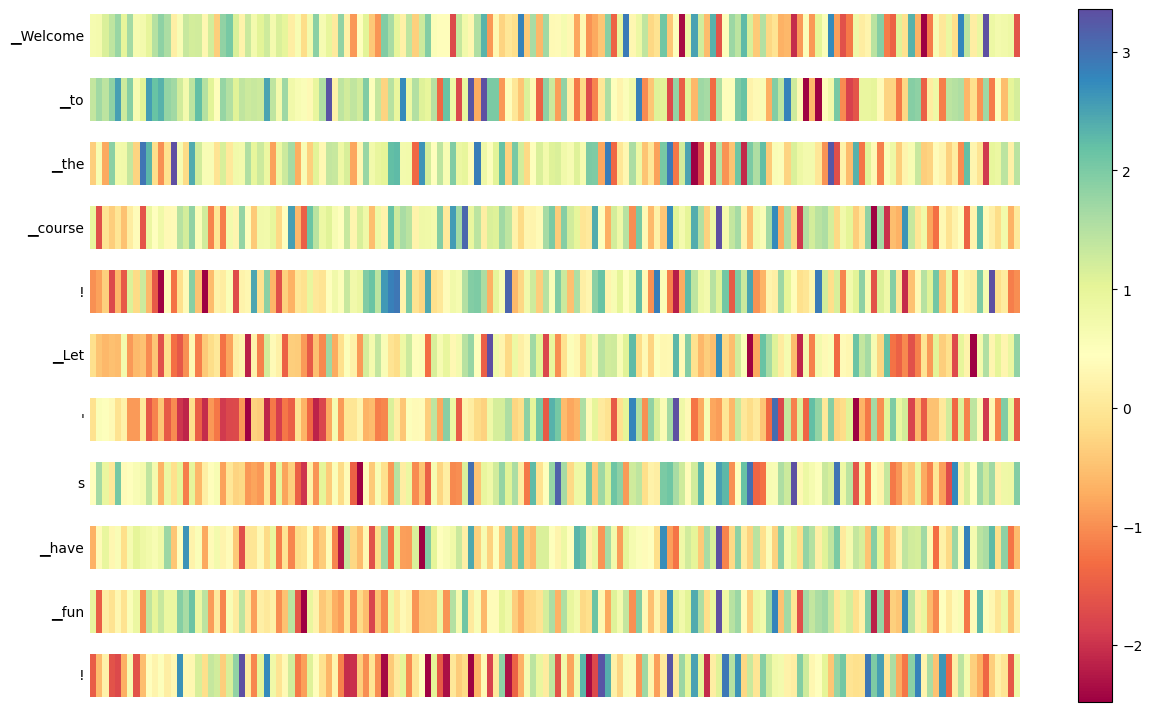

In [100]:
# Executando o modelo
output_seq, logits, encoder_hidden_states, decoder_hidden_states, attentions, decoder_attentions = run_model(Input)

# Vizualizando os embeddings de entrada e internos
print_input_embeddings(Input, encoder_hidden_states)


### Atenção

O processamento dos embeddings é feito com o mecanismo de self-attention. O self-attention opera como uma função sobre uma sequência de embeddings de entrada e gera uma sequência de mesmo tamanho como saída. Cada elemento da saída é uma soma ponderada de todos os elementos da entrada. Dessa forma, dado uma entrada $[\textbf{x}_{1}, \textbf{x}_{2},...,\textbf{x}_{n}]$, a saída $\textbf{y}_{i}$ é:

$$\textbf{y}_{i}=\sum_{j} w_{ij}\textbf{x}_{j}$$

A diferença da self-attention, está no fato que os pesos $w_{ij}$ não são parâmetros do modelo, mas obtidos por uma função entre $\textbf{x}_{i}$ e $\textbf{x}_{j}$:

$$\textbf{y}_{i}=\sum_{j} f(\textbf{x}_{i},\textbf{x}_{j})\textbf{x}_{j}$$

Dessa forma, o valor do vetor na posição $i$ da sequência de saída depende da relação do vetor de entrada na mesma posição com todos os vetores da sequência.

Os valores de atenção podem ser agrupados em uma matriz com todas as combinações i e j para $f(\textbf{x}_{i},\textbf{x}_{j})$), formando uma matrix $n$ x $n$. Abaixo pode-se visualizar algumas matrizes de atenção em uma das camadas do encoder do modelo. Nela podemos ver como o peso da soma ponderada é distribuído pelos diferentes tokens para formar a representação de saída de cada um.

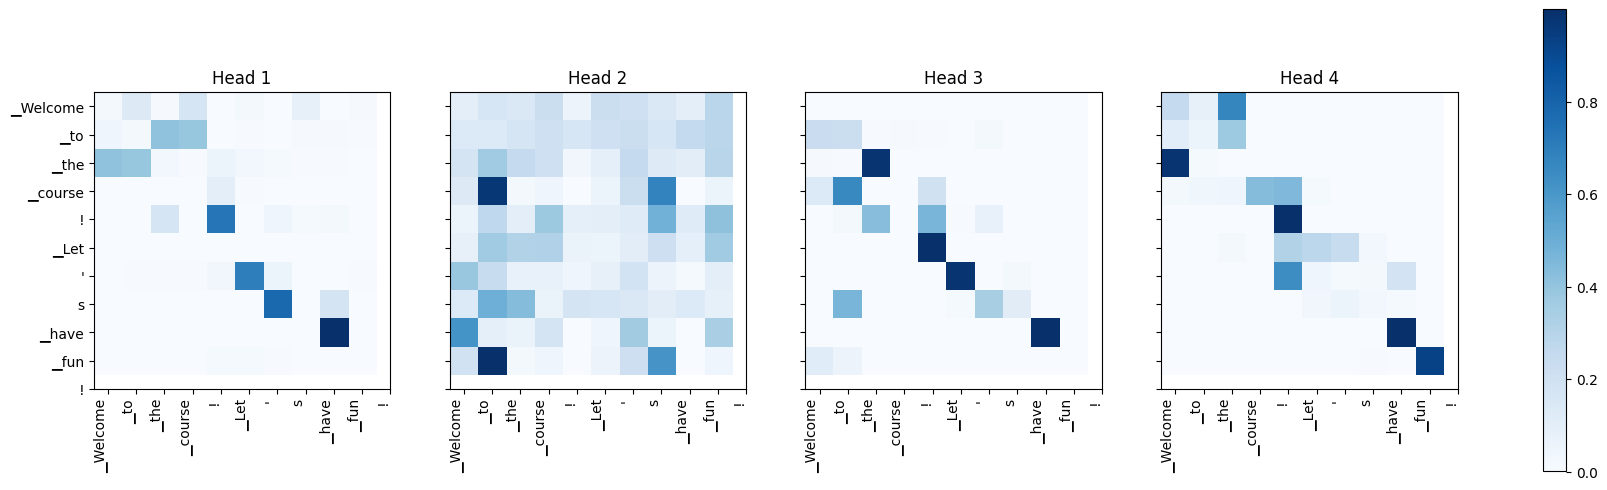

In [101]:
plot_encoder_attentions_maps(Input, attentions)

No decoder do modelo é inserido um mecanismo de atenção extra que permite os tokens do decoder (no nosso exemplo são os tokens da frase traduzida para o português) prestarem atenção nos tokens do encoder (frase em inglês). O príncipio de funcionamento é o mesmo descrito anteriormente, porém agora temos duas sequências de entrada gerando uma sequência de saída. Sendo a sequência do encoder $[\textbf{z}_{1},\textbf{z}_{2},...,\textbf{z}_{n}]$ e a sequência do decoder $[\textbf{x}_{1},\textbf{x}_{2},...,\textbf{x}_{n}]$, a saída na posição i é dada por:

$$\textbf{y}_{i}=\sum_{j} f(\textbf{x}_{i},\textbf{z}_{j})\textbf{z}_{j}$$

Dessa forma, a saída é uma soma ponderada dos tokens do encoder, onde os pesos de ponderação dependem dos tokens do decoder e encoder.

Abaixo pode-se visualizar algumas matrizes de atenção entre o decoder e encoder para o modelo.

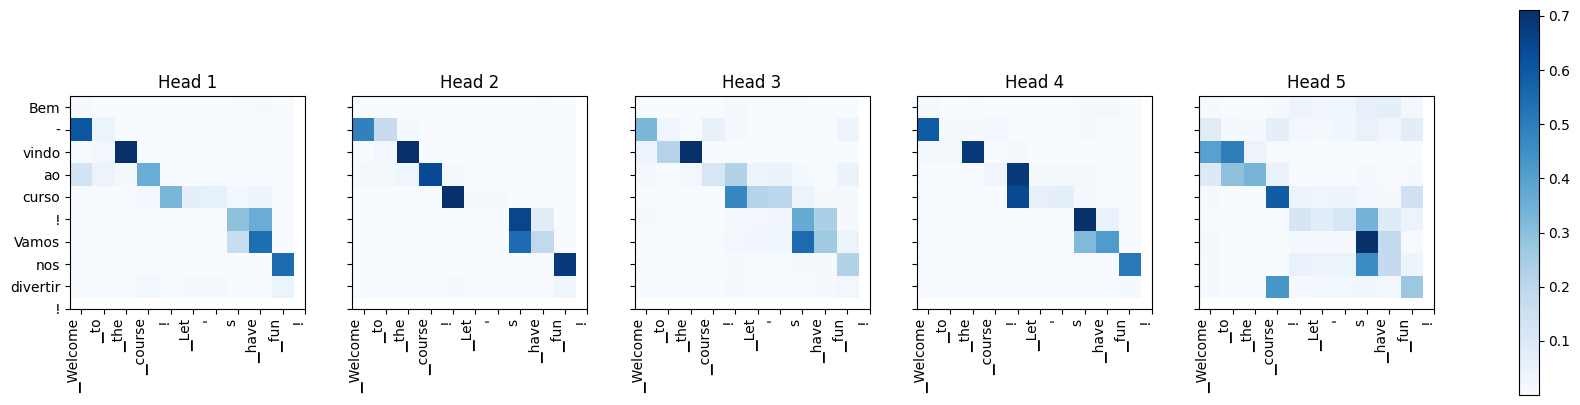

In [102]:
plot_encoder_decoder_attentions_maps(Input, output_seq, decoder_attentions)

### Saída

Após a última camada do decoder o modelo deve decidir qual o próximo token da sequência de saída. Para isso, uma última camada linear é utilizada para projetar o embedding da saída do decoder para um vetor com o tamanho do vocabulário. Cada posição do vetor indica um valor de importância do token correspondente no vocabulário. Esse vetor é chamado de logitos, se referindo a predições não-normalizadas do modelo.

Após isso, é necessário normalizar os valores de logitos para uma distribuição de probabilidade. Isso é feito utilizando a função softmax, a qual limita cada valor $x_{i}$ entre 0 e 1 e faz a soma total do vetor ser 1:

$$\frac{e^{x_{i}}}{\sum_{j} e^{x_{j}}}$$


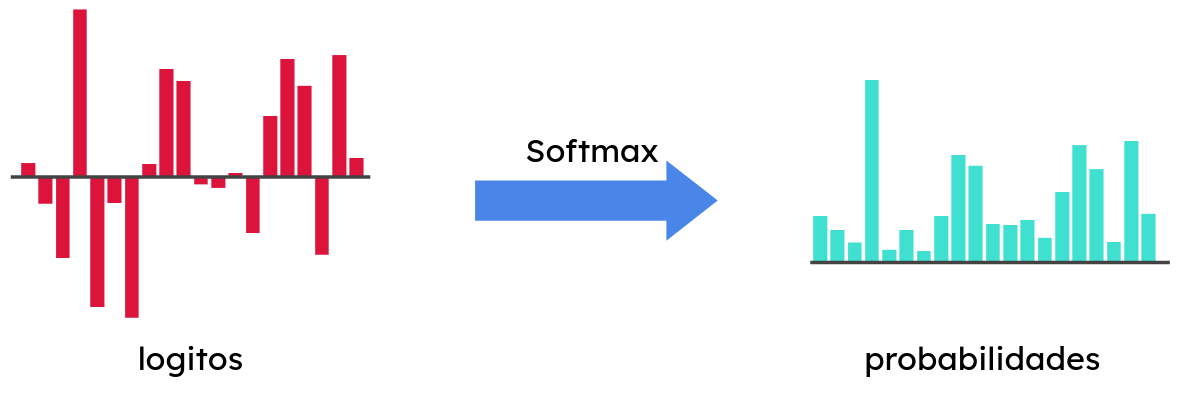

Com isso, temos na saída do modelo uma distribuição de probabilidades que pode ser utilizada para amostrar o próximo token de saída. A forma mais direta é escolher aquele de maior probabilidade, porém é possível também realizar uma amostragem ponderada, onde o vetor da saída define a probabilidade de um determinado token ser amostrado, ou seja, escolhido como o próximo da sequência de saída. Assim, os tokens mais prováveis de continuarem a sequência de saída terão maior probabilidade de serem selecionados.

In [103]:
out_dim = logits.size()
print(f"Dimensões da saída do modelo: {list(out_dim)}")
print(f"Batch: {out_dim[0]} - Tamanho da Sequência: {out_dim[1]} - Tamanho do Vocabulário: {out_dim[2]}")

Dimensões da saída do modelo: [1, 12, 54776]
Batch: 1 - Tamanho da Sequência: 12 - Tamanho do Vocabulário: 54776


Utilizando a distribuição de probabilidades da saída do modelo, pode-se escolher a sequência de tokens mais provável

In [104]:
tokenizer.decode(output_seq[0], skip_special_tokens=True)

'Bem-vindo ao curso! Vamos nos divertir!'

A sequência de saída do modelo pode ser escolhida por uma amostragem ponderada baseada no vetor de distribuição de probabilidades do decoder. Porém, devido ao método comum de treinamento dos modelos, os mesmos tendem a atribuir a maior parte da probabilidade a somente alguns tokens. Com isso, ao se amostrar diversas sequências de saída para uma mesma entrada, a variabilidade costuma ser baixa.

Para aumentar a variabilidade na amostragem da sequência de saída, ou seja, permitir o modelo ter mais liberdade para gerar textos diversificados, é introduzido o parâmetro **temperatura** $\tau$:

$$\frac{e^{x_{i} / \tau}}{\sum_{j} e^{x_{j} / \tau}}$$

Como a soma total dos itens após o softmax é sempre igual a 1, ao aumentar o valor da temperatura, a probabilidade é mais distribuída entre os itens, aproximando a distribuição a uma distribuição uniforme. Consequentemente, ao diminuir o valor da temperatura ($0<\tau< 1$), a probablidade dos itens mais relevantes é aumentada e as dos demais itens aproxima de zero. No limite onde $\tau = 0$, a distribuição é categórica e somente um elemento recebe 100% da probabilidade.


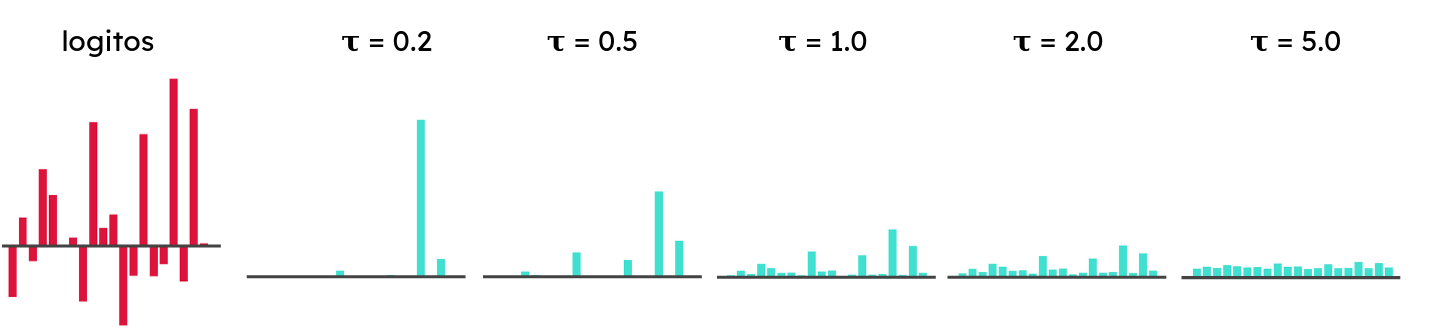

Abaixo pode-se visualizar a distribuição de probabilidade para a primeira palavra na sequência de saída do decoder. O gráfico apresenta somente as 10 palavras mais prováveis e a direita pode-se selecionar um valor de temperatura e então executar a célula para ver a mudança da distribuição.

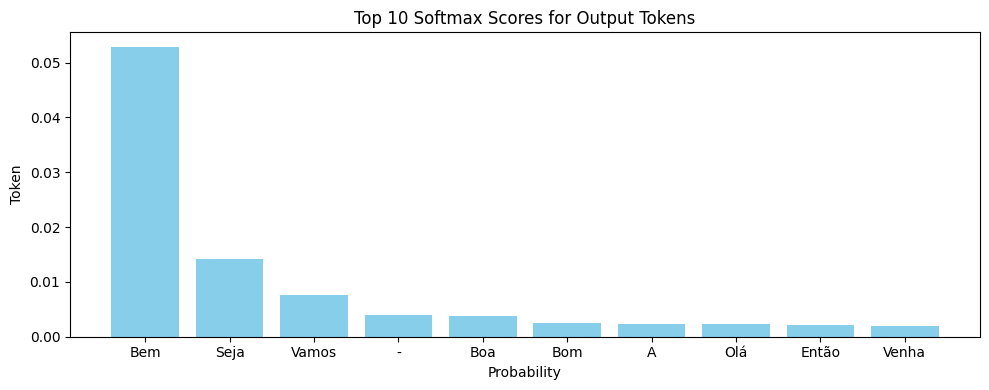

In [105]:
#@markdown A execução deste código é lenta devido ao tamanho do modelo e vetores utilizados
temperatura = 1.6 # @param @type {type: "slider", min:0, max:8, step: 0.1}

plot_softmax(logits, temperatura)

Por fim podemos amostrar diferentes sequências de saída com a temperatura selecionada. Quando a temperatura é zero, todas as saídas geradas serão iguais, pois o processo se torna determinístico. Conforme a temperatura é aumentada (pelo controle da célula anterior), mais diversificada se tornam as frases, porém se a temperatura for muito alta, as frases se aproximam cada vez mais de serem aleatórias.

In [106]:
sample_outputs(float(temperatura))


 Exemplos de frases amostradas com temperatura 1.6

1) Bem-vindo ao curso! Vamos nos divertir!
2) Bem-vindos ao curso! Vamos nos divertir!
3) Bem-vindos ao curso! Vamos nos divertir!
4) Bem-vindo ao curso! Vamos nos divertir!
5) Bem-vindo ao curso! Vamos nos divertir!


# Questões

## 1) Em quantos tokens são divididos a frase "Transformers work with self-attention modules."?

R: 10 tokens



In [107]:
input_text = "Transformers work with self-attention modules."
# Tokenização
tokens = tokenizer.tokenize(input_text)
print("Tokens:", tokens)
num_tokens = len(tokens)
print(f"Número de tokens na frase: {num_tokens}")

Tokens: ['▁Transform', 'ers', '▁work', '▁with', '▁self', '-', 'at', 'tention', '▁modules', '.']
Número de tokens na frase: 10


## 2) Para mesma frase anterior, qual o tamanho da matriz de atenção do encoder?

R: Se trata de uma matriz (11,11)

In [108]:
inputs = tokenizer(input_text, return_tensors="pt")

# Executar o modelo e obter as atenções do encoder usando generate
with torch.no_grad():
    output_seq = model.generate(**inputs, output_attentions=True, return_dict_in_generate=True, output_hidden_states=True)
    attentions = output_seq.encoder_attentions  # Atenções do encoder

# Calcular o tamanho da matriz de atenção do encoder
if attentions is not None:
    attention_matrix_size = attentions[0][0].shape[-2:]
    print(f"Tamanho da matriz de atenção do encoder: {attention_matrix_size}")
else:
    print("As atenções do encoder não foram retornadas.")



Tamanho da matriz de atenção do encoder: torch.Size([11, 11])


## 3) Para mesma frase anterior, qual é aproximadamente a probabiliadade do primeiro token de saída ser 'Transforma', quando a temperatura é 1.0? E para temperatura 1.8?

R: A probabilidade para ambos os casos é 0%

In [109]:
# Função para calcular a probabilidade de um token específico com diferentes temperaturas
def calculate_token_probability(target_token, temperature):
    # Executa o modelo para obter os logits
    with torch.no_grad():
        output_seq = model.generate(**inputs, do_sample=True, temperature=temperature, max_length=10)
        outputs = model(**inputs, decoder_input_ids=output_seq)
        logits = outputs.logits[0, 0]  # Logits para o primeiro token de saída

    # Calcular as probabilidades usando softmax
    probs = torch.nn.functional.softmax(logits / temperature, dim=-1)

    # Obter a probabilidade do token alvo
    target_token_id = tokenizer.convert_tokens_to_ids(target_token)
    target_prob = probs[target_token_id].item() if target_token_id in probs else 0.0

    return target_prob

# Calcular e imprimir as probabilidades para temperaturas 1.0 e 1.8
temperature_1_0 = 1.0
temperature_1_8 = 1.8

prob_1_0 = calculate_token_probability(target_token, temperature_1_0)
prob_1_8 = calculate_token_probability(target_token, temperature_1_8)

print(f"Probabilidade do token '{target_token}' com temperatura {temperature_1_0}: {prob_1_0:.4f}")
print(f"Probabilidade do token '{target_token}' com temperatura {temperature_1_8}: {prob_1_8:.4f}")



Probabilidade do token 'Transforma' com temperatura 1.0: 0.0000
Probabilidade do token 'Transforma' com temperatura 1.8: 0.0000
